In [1]:
#Importing necessary datasets
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np 


In [2]:
#Manually installing seaborn due to problems with the terminal
%pip install seaborn
#pip show seaborn
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [36]:
#Importing the datasets and selecting different timesteps to reduce dataset. This time 01.June kl 03.00 (kartverket = 30 cm water level)
file1 = f'/lustre/storeA/project/fou/hi/oper/norkyst_v3/forecast/his/2025/06/01/norkyst800_his_sdepth_20250601T00Z_m00_AN.nc'
ds_norkyst = xr.open_dataset(file1, engine="netcdf4").sel(ocean_time = '2025-06-01T03:00:00.000000000')

In [35]:
#check datafile 

ds_norkyst.ocean_time.values

np.datetime64('2025-06-01T03:00:00.000000000')

Explanation of code:
$\newline$
The transformation is an approach following xroms example on xarrays website:
$\newline$
$Z_0 = \frac{h_c \cdot S + h \cdot C}{h_c + h }$
$\newline$
$z = Z_0 (\zeta + h) + \zeta$
$\newline$
This creates a new datacoordinate Z_rho. 

Explanation: 
The code calculates the midpoint of each s-layer depending on which transformation is found in the V-transform. V-transform == 2 is more regulary used for newer ROMS models according to xroms. 
$\newline$
The calculations creates a variable $Z_0$ which is calculated by the use of:
$\newline$
hc = critical depth for stretching 
$\newline$
$s_rho$ = s-layers 
$\newline$
h = total depth
$\newline$
$Cs_r$ = stretching curve for the rho points
$\newline$
$\zeta$ = free surface  
$\newline$

$Z_0$ explains the depth at a given grid cell using the stretching features including the topography, but it excludes the surface layer.
$z_{rho}$ then includes the surface elevation by including $\zeta$ in the calculations and providing the dataset with a new coordinate defining the depth of the grid cells. 

$\newline$
$\newline$

Finding the 2m values:
1. Take the absolute value of the depths (using z_rho) and then subtracting two, to then be able to pick out the resulting numbers closest to zero. Those closest to zero will be the ones near 2meters depth in the model.
2. The diff.fillna function allows us to have zeros as a value for the landvalues rather than nan, as nan gives errors. Though this is corrected later in the code when plotting with seaborn to ensure the land is visibly different from the rest of the plot.  
3. Using argmin, I am selecting out the index of the number closest to zero, to find which s_layer it belongs to. This is why the dimension being called on is s_rho. 
4. Then selecting the index array defined above of those closest to two meters, I use this as an isel, only selecting out these z_rho values to create a new array. 

In [20]:
def finding_2m_layer(ds_name, title):
    #Define necessary variables used for the transformation from s_layer to depth
    hc = ds_name["hc"] #Critical depth for stretching
    cs_r = ds_name["Cs_r"] #stretching curve at rho points
    zeta = ds_name["zeta"] #.fillna(0) #free-surface 
    H = ds_name["h"] #bathymetry at rho-points (depth)
    Vtransform = ds_name["Vtransform"]
    s_rho = ds_name["s_rho"] #range 1,40. 40 is surface layer

    #Transformation process
    if Vtransform == 1:
        Z_0_rho = hc * (s_rho - cs_r) + cs_r * H
        z_rho = Z_0_rho + zeta * (1+Z_0_rho/H)
    elif Vtransform == 2:
        Z_0_rho = (hc * s_rho + cs_r * H) / (hc + H)
        z_rho = zeta + (zeta + H) * Z_0_rho

    ds_name.coords["z_rho"] = z_rho.transpose() #Corrects the dimensions

    ds_name["z_rho"] = z_rho

    #calculating the 2meters depth and creating two new arrays. One controlrun
    #for the actual values and one array containing the indexes of the values.
    z_rho_pos = abs(ds_name["z_rho"])
    diff = abs(z_rho_pos-2)
    diff = diff.fillna(0)
    index = diff.argmin(dim = "s_rho")
    close_to_2m_val = z_rho.isel(s_rho=index)
    #zero = nan in plot
    index = index.where(index != 0)
    ax = sns.heatmap(np.array(index)[::-1,::-1], vmin=25, cbar_kws={'label': 'Index'})
    ax.set_title(title)
    return index, close_to_2m_val, ax, ds_name

(<xarray.DataArray 'z_rho' (eta_rho: 1148, xi_rho: 2747)> Size: 25MB
 array([[nan, nan, nan, ..., 39., 39., 39.],
        [nan, nan, nan, ..., 39., 39., 39.],
        [nan, nan, nan, ..., 39., 39., 39.],
        ...,
        [nan, nan, nan, ..., 37., 36., 36.],
        [nan, nan, nan, ..., 37., 36., 36.],
        [nan, nan, nan, ..., 37., 36., 36.]], shape=(1148, 2747))
 Coordinates:
     lat_rho     (xi_rho, eta_rho) float64 25MB 54.29 54.3 54.3 ... 75.72 75.73
     lon_rho     (xi_rho, eta_rho) float64 25MB 8.7 8.69 8.679 ... 18.35 18.33
     ocean_time  datetime64[ns] 8B 2025-06-01T03:00:00
 Dimensions without coordinates: eta_rho, xi_rho,
 <xarray.DataArray (eta_rho: 1148, xi_rho: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -1.82594375,
         -1.82457383, -1.82457301],
        [        nan,         nan,         nan, ..., -1.82506873,
         -1.8236778 , -1.82454683],
        [        nan,         nan,         nan, ..., -1.82341008,
         -1.821628

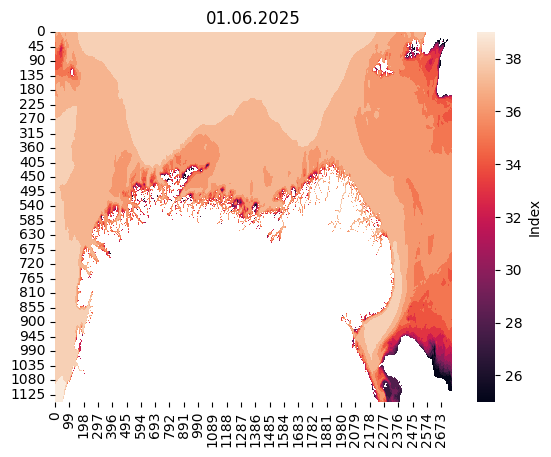

In [23]:
#First try
finding_2m_layer(ds_norkyst, title = "01.06.2025")

In [7]:
#Checking later in the day but for the same date, 23.00. Kartverket(91cm water level)
#Importing the datasets and selecting different timesteps to reduce dataset
file2 = f'/lustre/storeA/project/fou/hi/oper/norkyst_v3/forecast/his/2025/06/01/norkyst800_his_sdepth_20250601T00Z_m00_AN.nc'
ds_norkyst_nytid = xr.open_dataset(file2, engine="netcdf4").sel(ocean_time = '2025-06-01T23:00:00.000000000')

In [8]:
ds_norkyst_nytid.ocean_time.values

np.datetime64('2025-06-01T23:00:00.000000000')

(<xarray.DataArray 'z_rho' (xi_rho: 2747, eta_rho: 1148)> Size: 25MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [36., 36., 36., ..., 38., 38., 38.],
        [36., 36., 36., ..., 38., 38., 38.],
        [36., 36., 36., ..., 38., 38., 38.]], shape=(2747, 1148))
 Coordinates:
     lat_rho     (xi_rho, eta_rho) float64 25MB 54.29 54.3 54.3 ... 75.72 75.73
     lon_rho     (xi_rho, eta_rho) float64 25MB 8.7 8.69 8.679 ... 18.35 18.33
     ocean_time  datetime64[ns] 8B 2025-06-01T23:00:00
 Dimensions without coordinates: xi_rho, eta_rho,
 <xarray.DataArray (eta_rho: 1148, xi_rho: 2747)> Size: 25MB
 array([[        nan,         nan,         nan, ..., -2.32032168,
         -2.3202989 , -2.32032575],
        [        nan,         nan,         nan, ..., -2.3222841 ,
         -2.32199052, -2.32005503],
        [        nan,         nan,         nan, ..., -2.32506223,
         -2.324623

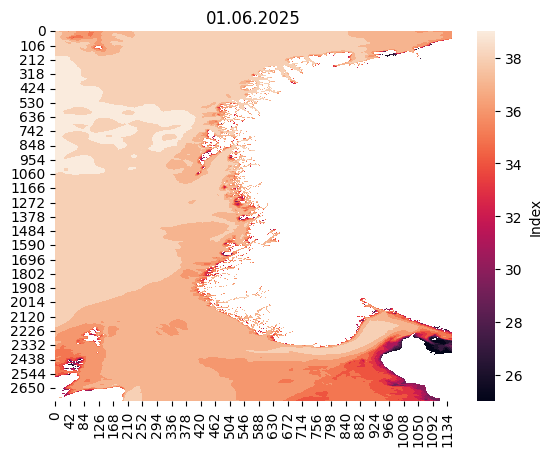

In [9]:
finding_2m_layer(ds_norkyst_nytid, title = "01.06.2025")

Verdiene ved 1092-1134 (x) og 2232 og 2226 (y) ser litt rare ut. Forsøker derfor å teste for mulig tidevann? 
De over er testa for to tider:
1. 01.06.2025 kl. 03.00. Her er vannstanden ifølge Kartverket 30cm. 
2. 01.06.2025 kl. 23.00. Her er vannstanden ifølge Kartverket 91cm. 

Det ser ut som plottet ble litt bedre i dette området av å gå utifra tidevannet, men jeg selekterer ut dette området for å vurdere nærmere i de to neste plottene, med samme tider respeketivt. 

In [10]:
ds_norkyst_oslofjord_1 = xr.open_dataset(file1, engine="netcdf4").sel(ocean_time = '2025-06-01T03:00:00.000000000', eta_rho = slice(0,300), xi_rho = slice(200,500))
ds_norkyst_oslofjord_2 = xr.open_dataset(file2, engine = "netcdf4").sel(ocean_time = '2025-06-01T23:00:00.000000000', eta_rho = slice(0,300), xi_rho = slice(200,500))

(<xarray.DataArray 'z_rho' (xi_rho: 300, eta_rho: 300)> Size: 720kB
 array([[nan, nan, nan, ..., 34., 34., 34.],
        [nan, nan, nan, ..., 34., 34., 34.],
        [nan, nan, nan, ..., 34., 34., 34.],
        ...,
        [34., 34., 35., ..., nan, nan, nan],
        [34., 34., 34., ..., nan, nan, nan],
        [34., 34., 34., ..., nan, nan, nan]], shape=(300, 300))
 Coordinates:
     lat_rho     (xi_rho, eta_rho) float64 720kB 55.52 55.52 55.52 ... 58.39 58.4
     lon_rho     (xi_rho, eta_rho) float64 720kB 9.889 9.879 ... 8.405 8.393
     ocean_time  datetime64[ns] 8B 2025-06-01T03:00:00
 Dimensions without coordinates: xi_rho, eta_rho,
 <xarray.DataArray (eta_rho: 300, xi_rho: 300)> Size: 720kB
 array([[        nan,         nan,         nan, ..., -2.16996495,
         -2.05150835, -1.94304983],
        [        nan,         nan,         nan, ..., -2.18099539,
         -2.06072464, -1.95141171],
        [        nan,         nan,         nan, ..., -1.81293237,
         -2.08271496, 

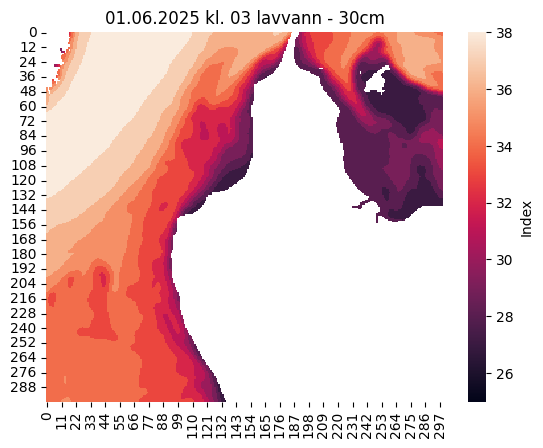

In [11]:
finding_2m_layer(ds_norkyst_oslofjord_1, title = "01.06.2025 kl. 03 lavvann - 30cm")

(<xarray.DataArray 'z_rho' (xi_rho: 300, eta_rho: 300)> Size: 720kB
 array([[nan, nan, nan, ..., 34., 34., 34.],
        [nan, nan, nan, ..., 34., 34., 34.],
        [nan, nan, nan, ..., 34., 34., 34.],
        ...,
        [34., 34., 34., ..., nan, nan, nan],
        [33., 33., 34., ..., nan, nan, nan],
        [33., 33., 33., ..., nan, nan, nan]], shape=(300, 300))
 Coordinates:
     lat_rho     (xi_rho, eta_rho) float64 720kB 55.52 55.52 55.52 ... 58.39 58.4
     lon_rho     (xi_rho, eta_rho) float64 720kB 9.889 9.879 ... 8.405 8.393
     ocean_time  datetime64[ns] 8B 2025-06-01T23:00:00
 Dimensions without coordinates: xi_rho, eta_rho,
 <xarray.DataArray (eta_rho: 300, xi_rho: 300)> Size: 720kB
 array([[        nan,         nan,         nan, ..., -1.90324613,
         -2.17377488, -2.04183612],
        [        nan,         nan,         nan, ..., -1.91430099,
         -2.18507951, -2.05207086],
        [        nan,         nan,         nan, ..., -1.93929254,
         -1.8178636 , 

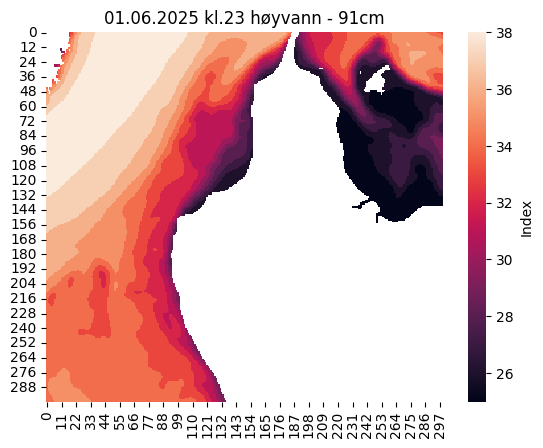

In [12]:
finding_2m_layer(ds_norkyst_oslofjord_2, title= "01.06.2025 kl.23 høyvann - 91cm")

Når man ser nærmere på disse figurene så tyder det på at tidevannet er årsaken til de dypere lagene kanskje? 

Next goal: Check for the dataset used in the ml project if storeB is up and running. The last file in the storeB is 2024. 